In [1]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import pickle
import imblearn
import numpy as np
from imblearn.over_sampling import SMOTE
import sklearn
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import DecisionTreeClassifier
print("done")

done


In [7]:
#Load the data set
data = pd.read_csv('LoanData.csv')
print(data)

      Loan_ID  Gender Married Dependents     Education Self_Employed  \
0    LP001002    Male      No          0      Graduate            No   
1    LP001003    Male     Yes          1      Graduate            No   
2    LP001005    Male     Yes          0      Graduate           Yes   
3    LP001006    Male     Yes          0  Not Graduate            No   
4    LP001008    Male      No          0      Graduate            No   
..        ...     ...     ...        ...           ...           ...   
609  LP002978  Female      No          0      Graduate            No   
610  LP002979    Male     Yes         3+      Graduate            No   
611  LP002983    Male     Yes          1      Graduate            No   
612  LP002984    Male     Yes          2      Graduate            No   
613  LP002990  Female      No          0      Graduate           Yes   

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0               5849                0.0         NaN           

In [8]:
# look at few top rows
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [9]:
# describe dataset
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


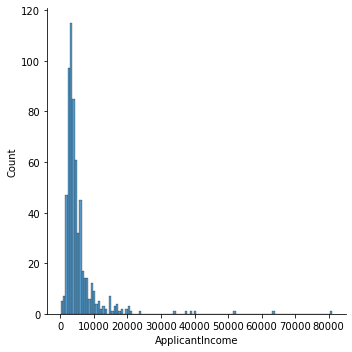

In [11]:
sns.displot(data.ApplicantIncome,kde=False)

Loan Amount has missing values , we can’t plot it directly. One solution is to drop the missing values rows then plot it, we can do this using the dropna function

<AxesSubplot:xlabel='ApplicantIncome'>

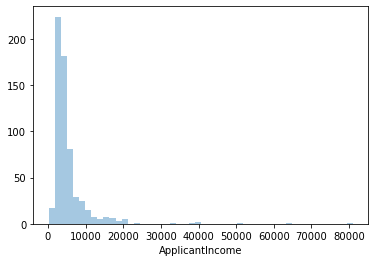

In [26]:
sns.distplot(data.ApplicantIncome.dropna(),kde=False)

<AxesSubplot:xlabel='Education', ylabel='ApplicantIncome'>

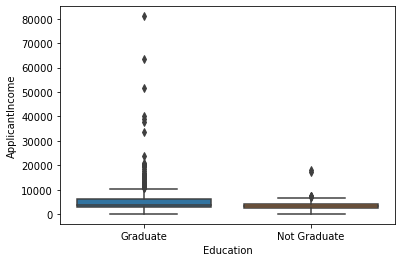

In [27]:
sns.boxplot(x='Education',y='ApplicantIncome',data=data)

 we can see that the graduates have more outliers which means that the people with huge income are most likely well educated.

In [28]:
# lets check first how many there are for each variable.
data.apply(lambda x: sum(x.isnull()),axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [30]:
#  Deal with missing value
data['Gender'] = data['Gender'].fillna(data['Gender'].mode()[0])
data['Married'] = data['Married'].fillna(data['Married'].mode()[0])
data['Dependents'] = data['Dependents'].fillna(data['Dependents'].mode()[0])
data['Self_Employed'] = data['Self_Employed'].fillna(data['Self_Employed'].mode()[0])


In [31]:
# using median values to impute the numerical columns
data['LoanAmount'] = data['LoanAmount'].fillna(data['LoanAmount'].median())
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].median())
data['Credit_History'] = data['Credit_History'].fillna(data['Credit_History'].median())
data = data[data['ApplicantIncome'] < 25000]
data = data[data['CoapplicantIncome'] < 10000]
data = data[data['LoanAmount'] < 400]


In [32]:
# recheck missing value
data.apply(lambda x: sum(x.isnull()),axis=0)

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [33]:
#data['ApplicantIncome'] = np.log(data['ApplicantIncome'])
#data['CoapplicantIncome'] = np.log1p(data['CoapplicantIncome'])
data = data.drop(['Loan_ID'], axis = 1)
data['Gender'] = data['Gender'].replace(('Male','Female'),(1, 0))
data['Married'] = data['Married'].replace(('Yes','No'),(1, 0))
data['Education'] = data['Education'].replace(('Graduate','Not Graduate'), (1, 0))
data['Self_Employed'] = data['Self_Employed'].replace(('Yes','No'), (1, 0))
data['Loan_Status'] = data['Loan_Status'].replace(('Y','N'), (1, 0))


In [34]:
# as seen above that Urban and Semi Urban Property have very similar Impact on Loan Status, so, we will merge them together
data['Property_Area'] = data['Property_Area'].replace(('Urban','Semiurban', 'Rural'),(2, 1, 0))


In [35]:
# as seen above that apart from 0 dependents, all are similar hence, we merge them to avoid any confusion
data['Dependents'] = data['Dependents'].replace(('0', '1', '2', '3+'), (0, 1, 2, 3))
y = data['Loan_Status']
x = data.drop(['Loan_Status'], axis = 1)


In [36]:
x_resample, y_resample  = SMOTE().fit_resample(x, y.values.ravel())


In [37]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_resample, y_resample, test_size = 0.2, random_state = 0)
#model =  LogisticRegression()
model = RandomForestClassifier(n_estimators=100)
model.fit(x_train, y_train)
file = open('loan_status2.pkl', 'wb')
pickle.dump(model, file)

In [45]:
accuracy = model.score(x_test,y_test)
print("RandomForestClassifier Accuracy :",accuracy*100,'%')


RandomForestClassifier Accuracy : 88.41463414634147 %


In [46]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_resample, y_resample, test_size = 0.2, random_state = 0)
model =  LogisticRegression()
# model = RandomForestClassifier(n_estimators=100)
model.fit(x_train, y_train)
accuracy = model.score(x_test,y_test)
print("LogisticRegression Accuracy :",accuracy*100,'%')


LogisticRegression Accuracy : 74.39024390243902 %


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
